ViT(HARSH)

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch
from transformers import ViTForImageClassification, ViTFeatureExtractor
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from transformers import ViTForImageClassification, ViTFeatureExtractor
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

class ViTEvaluator:
    def __init__(self, class_names, device=None):
        self.class_names = class_names
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load ViT model
        self.model = ViTForImageClassification.from_pretrained(
            "google/vit-base-patch16-224-in21k", num_labels=len(class_names)
        )

        self.model.eval()
        self.model.to(self.device)

        # Load feature extractor for input shape information
        self.feature_extractor = ViTFeatureExtractor.from_pretrained(
            "google/vit-base-patch16-224-in21k"
        )

    def predict_batch(self, images):
        # Ensure images are in the correct shape
        if images.shape[-2:] != (self.feature_extractor.size['height'], self.feature_extractor.size['width']):
            raise ValueError(f"Expected image size {self.feature_extractor.size['height']}x{self.feature_extractor.size['width']}, but got {images.shape[-2]}x{images.shape[-1]}")

        # Move images to the correct device
        images = images.to(self.device)

        with torch.no_grad():
            outputs = self.model(pixel_values=images)
            predictions = outputs.logits.argmax(-1)

        return [self.class_names[pred.item()] for pred in predictions]

    def evaluate(self, test_loader):
        y_true = []
        y_pred = []

        for images, labels in tqdm(test_loader, desc="Evaluating"):
            predicted_classes = self.predict_batch(images)
            y_true.extend([self.class_names[label.item()] for label in labels])
            y_pred.extend(predicted_classes)

        return classification_report(y_true, y_pred, target_names=self.class_names), \
               confusion_matrix(y_true, y_pred, labels=self.class_names)


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets, transforms
import torch
import random
class RandomApply(object):
    def __init__(self, transform, p=0.5):
        self.transform = transform
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            return self.transform(img)
        return img

# Define the augmentations and transformations
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Randomly crop and resize the image

    # Geometric transformations
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=30),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.2, 0.2),
        scale=(0.8, 1.2),
        shear=15
    ),
    # Color transformations
    transforms.ColorJitter(
        brightness=0.4,
        contrast=0.4,
        saturation=0.4,
        hue=0.2
    ),
    RandomApply(transforms.GaussianBlur(kernel_size=3), p=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
      transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=30),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.2, 0.2),
        scale=(0.8, 1.2),
        shear=15
    ),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load the dataset
full_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/clothing_data', transform=transform_train)

# Split into train and validation sets
train_size = int(0.6 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Apply transforms
train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [ ]:
# Get class names from the dataset
class_names = full_dataset.classes

# Print class names
print("Class Names:", class_names)  # Replace with your actual class names

evaluator = ViTEvaluator(class_names)

# Evaluate the model
report, conf_matrix  = evaluator.evaluate(val_loader)

print("Classification Report:")
print(report)
print("\nConfusion Matrix:")
print(conf_matrix)

Class Names: ['female_bodycon', 'female_pant_suit_top', 'female_pants_bottom', 'informal_cloths_men', 'informal_cloths_women', 'male_pants', 'shirt_men', 'suits_men']


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Evaluating: 100%|██████████| 40/40 [01:49<00:00,  2.74s/it]

Classification Report:
                       precision    recall  f1-score   support

       female_bodycon       0.04      0.03      0.03        34
 female_pant_suit_top       0.21      0.42      0.28        38
  female_pants_bottom       0.14      0.07      0.09        42
  informal_cloths_men       0.08      0.05      0.06        42
informal_cloths_women       0.08      0.19      0.12        32
           male_pants       0.00      0.00      0.00        42
            shirt_men       0.06      0.02      0.03        45
            suits_men       0.00      0.00      0.00        45

             accuracy                           0.09       320
            macro avg       0.08      0.10      0.08       320
         weighted avg       0.07      0.09      0.07       320


Confusion Matrix:
[[ 1  2  3  5 17  3  1  2]
 [ 2 16  0  7  8  2  1  2]
 [ 1  5  3  2 11  2  0 18]
 [ 6  9  6  2  5  2  7  5]
 [ 1  6  3  3  6  8  1  4]
 [ 0 10  3  1  8  0  3 17]
 [11  3  4  2 11 11  1  2]
 [ 5 27  0

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Epoch 1/100: 100%|██████████| 60/60 [03:01<00:00,  3.03s/it]


Epoch 1/100
Train Loss: 1.6210, Train Accuracy: 0.5062
Val Loss: 1.1839, Val Accuracy: 0.6562


Epoch 2/100: 100%|██████████| 60/60 [00:19<00:00,  3.14it/s]


Epoch 2/100
Train Loss: 0.8870, Train Accuracy: 0.7833
Val Loss: 0.7270, Val Accuracy: 0.8031


Epoch 3/100: 100%|██████████| 60/60 [00:19<00:00,  3.12it/s]


Epoch 3/100
Train Loss: 0.5326, Train Accuracy: 0.8688
Val Loss: 0.6971, Val Accuracy: 0.7531


Epoch 4/100: 100%|██████████| 60/60 [00:19<00:00,  3.07it/s]


Epoch 4/100
Train Loss: 0.4149, Train Accuracy: 0.9021
Val Loss: 0.5022, Val Accuracy: 0.8375


Epoch 5/100: 100%|██████████| 60/60 [00:19<00:00,  3.07it/s]


Epoch 5/100
Train Loss: 0.2668, Train Accuracy: 0.9333
Val Loss: 0.5126, Val Accuracy: 0.8250


Epoch 6/100: 100%|██████████| 60/60 [00:19<00:00,  3.10it/s]


Epoch 6/100
Train Loss: 0.3041, Train Accuracy: 0.9229
Val Loss: 0.5848, Val Accuracy: 0.7875


Epoch 7/100: 100%|██████████| 60/60 [00:19<00:00,  3.09it/s]


Epoch 7/100
Train Loss: 0.2058, Train Accuracy: 0.9563
Val Loss: 0.6447, Val Accuracy: 0.7875


Epoch 8/100: 100%|██████████| 60/60 [00:19<00:00,  3.07it/s]


Epoch 8/100
Train Loss: 0.1963, Train Accuracy: 0.9458
Val Loss: 0.6322, Val Accuracy: 0.7781


Epoch 9/100: 100%|██████████| 60/60 [00:19<00:00,  3.07it/s]


Epoch 9/100
Train Loss: 0.2426, Train Accuracy: 0.9354
Val Loss: 0.6810, Val Accuracy: 0.7656


Epoch 10/100: 100%|██████████| 60/60 [00:19<00:00,  3.11it/s]


Epoch 10/100
Train Loss: 0.1482, Train Accuracy: 0.9604
Val Loss: 0.6362, Val Accuracy: 0.7906


Epoch 11/100: 100%|██████████| 60/60 [00:19<00:00,  3.05it/s]


Epoch 11/100
Train Loss: 0.1863, Train Accuracy: 0.9521
Val Loss: 0.9225, Val Accuracy: 0.7438


Epoch 12/100: 100%|██████████| 60/60 [00:19<00:00,  3.09it/s]


Epoch 12/100
Train Loss: 0.1547, Train Accuracy: 0.9521
Val Loss: 0.6509, Val Accuracy: 0.8000


Epoch 13/100: 100%|██████████| 60/60 [00:19<00:00,  3.08it/s]


Epoch 13/100
Train Loss: 0.0884, Train Accuracy: 0.9750
Val Loss: 0.8918, Val Accuracy: 0.7656


Epoch 14/100: 100%|██████████| 60/60 [00:19<00:00,  3.09it/s]


Epoch 14/100
Train Loss: 0.0957, Train Accuracy: 0.9812
Val Loss: 0.6244, Val Accuracy: 0.8094


Epoch 15/100: 100%|██████████| 60/60 [00:19<00:00,  3.10it/s]


Epoch 15/100
Train Loss: 0.1034, Train Accuracy: 0.9729
Val Loss: 0.7726, Val Accuracy: 0.7688


Epoch 16/100: 100%|██████████| 60/60 [00:19<00:00,  3.11it/s]


Epoch 16/100
Train Loss: 0.1471, Train Accuracy: 0.9625
Val Loss: 0.8000, Val Accuracy: 0.7688


Epoch 17/100: 100%|██████████| 60/60 [00:19<00:00,  3.07it/s]


Epoch 17/100
Train Loss: 0.0949, Train Accuracy: 0.9792
Val Loss: 0.6641, Val Accuracy: 0.8031


Epoch 18/100: 100%|██████████| 60/60 [00:19<00:00,  3.07it/s]


Epoch 18/100
Train Loss: 0.1065, Train Accuracy: 0.9708
Val Loss: 0.7800, Val Accuracy: 0.7562


Epoch 19/100: 100%|██████████| 60/60 [00:19<00:00,  3.11it/s]


Epoch 19/100
Train Loss: 0.0588, Train Accuracy: 0.9833
Val Loss: 0.8896, Val Accuracy: 0.7406


Epoch 20/100: 100%|██████████| 60/60 [00:19<00:00,  3.12it/s]


Epoch 20/100
Train Loss: 0.1201, Train Accuracy: 0.9771
Val Loss: 0.6061, Val Accuracy: 0.8313


Epoch 21/100: 100%|██████████| 60/60 [00:19<00:00,  3.11it/s]


Epoch 21/100
Train Loss: 0.0660, Train Accuracy: 0.9875
Val Loss: 0.7158, Val Accuracy: 0.7937


Epoch 22/100: 100%|██████████| 60/60 [00:19<00:00,  3.02it/s]


Epoch 22/100
Train Loss: 0.1085, Train Accuracy: 0.9729
Val Loss: 0.8501, Val Accuracy: 0.7781


Epoch 23/100: 100%|██████████| 60/60 [00:19<00:00,  3.09it/s]


Epoch 23/100
Train Loss: 0.1093, Train Accuracy: 0.9708
Val Loss: 0.7482, Val Accuracy: 0.7688


Epoch 24/100: 100%|██████████| 60/60 [00:19<00:00,  3.11it/s]


Epoch 24/100
Train Loss: 0.0609, Train Accuracy: 0.9833
Val Loss: 0.9785, Val Accuracy: 0.7375


Epoch 25/100: 100%|██████████| 60/60 [00:19<00:00,  3.11it/s]


Epoch 25/100
Train Loss: 0.1715, Train Accuracy: 0.9396
Val Loss: 1.0100, Val Accuracy: 0.7375


Epoch 26/100: 100%|██████████| 60/60 [00:19<00:00,  3.07it/s]


Epoch 26/100
Train Loss: 0.1817, Train Accuracy: 0.9563
Val Loss: 1.0393, Val Accuracy: 0.7250


Epoch 27/100: 100%|██████████| 60/60 [00:19<00:00,  3.08it/s]


Epoch 27/100
Train Loss: 0.1154, Train Accuracy: 0.9625
Val Loss: 0.8841, Val Accuracy: 0.7656


Epoch 28/100: 100%|██████████| 60/60 [00:19<00:00,  3.10it/s]


Epoch 28/100
Train Loss: 0.0700, Train Accuracy: 0.9833
Val Loss: 1.0456, Val Accuracy: 0.7312


Epoch 29/100: 100%|██████████| 60/60 [00:19<00:00,  3.11it/s]


Epoch 29/100
Train Loss: 0.0941, Train Accuracy: 0.9729
Val Loss: 1.0226, Val Accuracy: 0.7531


Epoch 30/100: 100%|██████████| 60/60 [00:19<00:00,  3.11it/s]


Epoch 30/100
Train Loss: 0.0792, Train Accuracy: 0.9771
Val Loss: 0.7373, Val Accuracy: 0.7969


Epoch 31/100: 100%|██████████| 60/60 [00:19<00:00,  3.07it/s]


Epoch 31/100
Train Loss: 0.0317, Train Accuracy: 0.9917
Val Loss: 0.6757, Val Accuracy: 0.8000


Epoch 32/100: 100%|██████████| 60/60 [00:19<00:00,  3.08it/s]


Epoch 32/100
Train Loss: 0.0110, Train Accuracy: 1.0000
Val Loss: 0.7768, Val Accuracy: 0.7969


Epoch 33/100: 100%|██████████| 60/60 [00:19<00:00,  3.08it/s]


Epoch 33/100
Train Loss: 0.0138, Train Accuracy: 0.9979
Val Loss: 0.9317, Val Accuracy: 0.7688


Epoch 34/100: 100%|██████████| 60/60 [00:19<00:00,  3.11it/s]


Epoch 34/100
Train Loss: 0.0373, Train Accuracy: 0.9938
Val Loss: 0.7615, Val Accuracy: 0.8000


Epoch 35/100: 100%|██████████| 60/60 [00:19<00:00,  3.04it/s]


Epoch 35/100
Train Loss: 0.0516, Train Accuracy: 0.9792
Val Loss: 0.9023, Val Accuracy: 0.7625


Epoch 36/100: 100%|██████████| 60/60 [00:19<00:00,  3.08it/s]


Epoch 36/100
Train Loss: 0.0784, Train Accuracy: 0.9729
Val Loss: 1.1624, Val Accuracy: 0.7125


Epoch 37/100: 100%|██████████| 60/60 [00:19<00:00,  3.10it/s]


Epoch 37/100
Train Loss: 0.1926, Train Accuracy: 0.9354
Val Loss: 0.9726, Val Accuracy: 0.7094


Epoch 38/100: 100%|██████████| 60/60 [00:19<00:00,  3.10it/s]


Epoch 38/100
Train Loss: 0.0924, Train Accuracy: 0.9771
Val Loss: 0.9725, Val Accuracy: 0.7500


Epoch 39/100: 100%|██████████| 60/60 [00:19<00:00,  3.11it/s]


Epoch 39/100
Train Loss: 0.0367, Train Accuracy: 0.9938
Val Loss: 0.7752, Val Accuracy: 0.7875


Epoch 40/100: 100%|██████████| 60/60 [00:19<00:00,  3.07it/s]


Epoch 40/100
Train Loss: 0.0509, Train Accuracy: 0.9854
Val Loss: 0.7669, Val Accuracy: 0.8000


Epoch 41/100: 100%|██████████| 60/60 [00:19<00:00,  3.08it/s]


Epoch 41/100
Train Loss: 0.0359, Train Accuracy: 0.9917
Val Loss: 0.9300, Val Accuracy: 0.7688


Epoch 42/100: 100%|██████████| 60/60 [00:19<00:00,  3.11it/s]


Epoch 42/100
Train Loss: 0.0354, Train Accuracy: 0.9917
Val Loss: 0.8701, Val Accuracy: 0.7656


Epoch 43/100: 100%|██████████| 60/60 [00:19<00:00,  3.10it/s]


Epoch 43/100
Train Loss: 0.0484, Train Accuracy: 0.9854
Val Loss: 0.7980, Val Accuracy: 0.7750


Epoch 44/100: 100%|██████████| 60/60 [00:19<00:00,  3.09it/s]


Epoch 44/100
Train Loss: 0.0496, Train Accuracy: 0.9896
Val Loss: 0.9636, Val Accuracy: 0.7656


Epoch 45/100: 100%|██████████| 60/60 [00:19<00:00,  3.08it/s]


Epoch 45/100
Train Loss: 0.0477, Train Accuracy: 0.9833
Val Loss: 0.9580, Val Accuracy: 0.7281


Epoch 46/100: 100%|██████████| 60/60 [00:19<00:00,  3.09it/s]


Epoch 46/100
Train Loss: 0.0360, Train Accuracy: 0.9833
Val Loss: 0.8563, Val Accuracy: 0.7906


Epoch 47/100: 100%|██████████| 60/60 [00:19<00:00,  3.04it/s]


Epoch 47/100
Train Loss: 0.0254, Train Accuracy: 0.9917
Val Loss: 0.7780, Val Accuracy: 0.7688


Epoch 48/100: 100%|██████████| 60/60 [00:19<00:00,  3.09it/s]


Epoch 48/100
Train Loss: 0.0362, Train Accuracy: 0.9896
Val Loss: 0.9804, Val Accuracy: 0.7812


Epoch 49/100: 100%|██████████| 60/60 [00:19<00:00,  3.07it/s]


Epoch 49/100
Train Loss: 0.0136, Train Accuracy: 0.9958
Val Loss: 0.9664, Val Accuracy: 0.7844


Epoch 50/100: 100%|██████████| 60/60 [00:19<00:00,  3.08it/s]


Epoch 50/100
Train Loss: 0.0799, Train Accuracy: 0.9750
Val Loss: 0.9362, Val Accuracy: 0.7250


Epoch 51/100: 100%|██████████| 60/60 [00:19<00:00,  3.10it/s]


Epoch 51/100
Train Loss: 0.0419, Train Accuracy: 0.9833
Val Loss: 0.9230, Val Accuracy: 0.7688


Epoch 52/100: 100%|██████████| 60/60 [00:19<00:00,  3.10it/s]


Epoch 52/100
Train Loss: 0.0244, Train Accuracy: 0.9896
Val Loss: 1.2430, Val Accuracy: 0.7406


Epoch 53/100: 100%|██████████| 60/60 [00:19<00:00,  3.09it/s]


Epoch 53/100
Train Loss: 0.1116, Train Accuracy: 0.9729
Val Loss: 1.2422, Val Accuracy: 0.6969


Epoch 54/100: 100%|██████████| 60/60 [00:19<00:00,  3.07it/s]


Epoch 54/100
Train Loss: 0.0851, Train Accuracy: 0.9771
Val Loss: 1.1245, Val Accuracy: 0.7406


Epoch 55/100: 100%|██████████| 60/60 [00:19<00:00,  3.09it/s]


Epoch 55/100
Train Loss: 0.0450, Train Accuracy: 0.9896
Val Loss: 1.1054, Val Accuracy: 0.7375


Epoch 56/100: 100%|██████████| 60/60 [00:19<00:00,  3.11it/s]


Epoch 56/100
Train Loss: 0.1128, Train Accuracy: 0.9667
Val Loss: 1.4850, Val Accuracy: 0.6625


Epoch 57/100: 100%|██████████| 60/60 [00:19<00:00,  3.12it/s]


Epoch 57/100
Train Loss: 0.1226, Train Accuracy: 0.9625
Val Loss: 1.3460, Val Accuracy: 0.6844


Epoch 58/100: 100%|██████████| 60/60 [00:19<00:00,  3.08it/s]


Epoch 58/100
Train Loss: 0.1086, Train Accuracy: 0.9708
Val Loss: 1.1674, Val Accuracy: 0.7312


Epoch 59/100: 100%|██████████| 60/60 [00:19<00:00,  3.07it/s]


Epoch 59/100
Train Loss: 0.0990, Train Accuracy: 0.9750
Val Loss: 0.9450, Val Accuracy: 0.7500


Epoch 60/100: 100%|██████████| 60/60 [00:19<00:00,  3.08it/s]


Epoch 60/100
Train Loss: 0.0238, Train Accuracy: 0.9958
Val Loss: 0.8358, Val Accuracy: 0.7812


Epoch 61/100: 100%|██████████| 60/60 [00:19<00:00,  3.12it/s]


Epoch 61/100
Train Loss: 0.0211, Train Accuracy: 0.9938
Val Loss: 0.8362, Val Accuracy: 0.7781


Epoch 62/100: 100%|██████████| 60/60 [00:19<00:00,  3.12it/s]


Epoch 62/100
Train Loss: 0.0077, Train Accuracy: 1.0000
Val Loss: 0.9682, Val Accuracy: 0.7812


Epoch 63/100: 100%|██████████| 60/60 [00:19<00:00,  3.12it/s]


Epoch 63/100
Train Loss: 0.0167, Train Accuracy: 0.9979
Val Loss: 0.9739, Val Accuracy: 0.7500


Epoch 64/100: 100%|██████████| 60/60 [00:19<00:00,  3.08it/s]


Epoch 64/100
Train Loss: 0.0073, Train Accuracy: 1.0000
Val Loss: 1.0012, Val Accuracy: 0.7562


Epoch 65/100: 100%|██████████| 60/60 [00:19<00:00,  3.08it/s]


Epoch 65/100
Train Loss: 0.0268, Train Accuracy: 0.9917
Val Loss: 1.2860, Val Accuracy: 0.7312


Epoch 66/100: 100%|██████████| 60/60 [00:19<00:00,  3.11it/s]


Epoch 66/100
Train Loss: 0.1863, Train Accuracy: 0.9521
Val Loss: 1.7257, Val Accuracy: 0.6062


Epoch 67/100: 100%|██████████| 60/60 [00:19<00:00,  3.11it/s]


Epoch 67/100
Train Loss: 0.2149, Train Accuracy: 0.9375
Val Loss: 0.9349, Val Accuracy: 0.7312


Epoch 68/100: 100%|██████████| 60/60 [00:19<00:00,  3.10it/s]


Epoch 68/100
Train Loss: 0.0744, Train Accuracy: 0.9812
Val Loss: 0.9407, Val Accuracy: 0.7250


Epoch 69/100: 100%|██████████| 60/60 [00:19<00:00,  3.08it/s]


Epoch 69/100
Train Loss: 0.0132, Train Accuracy: 0.9979
Val Loss: 0.8173, Val Accuracy: 0.7750


Epoch 70/100: 100%|██████████| 60/60 [00:19<00:00,  3.06it/s]


Epoch 70/100
Train Loss: 0.0073, Train Accuracy: 1.0000
Val Loss: 0.8476, Val Accuracy: 0.7781


Epoch 71/100: 100%|██████████| 60/60 [00:19<00:00,  3.10it/s]


Epoch 71/100
Train Loss: 0.0347, Train Accuracy: 0.9875
Val Loss: 0.9352, Val Accuracy: 0.7375


Epoch 72/100: 100%|██████████| 60/60 [00:19<00:00,  3.11it/s]


Epoch 72/100
Train Loss: 0.0117, Train Accuracy: 0.9958
Val Loss: 1.0964, Val Accuracy: 0.7406


Epoch 73/100: 100%|██████████| 60/60 [00:19<00:00,  3.08it/s]


Epoch 73/100
Train Loss: 0.0139, Train Accuracy: 0.9958
Val Loss: 0.8662, Val Accuracy: 0.7875


Epoch 74/100: 100%|██████████| 60/60 [00:19<00:00,  3.08it/s]


Epoch 74/100
Train Loss: 0.0365, Train Accuracy: 0.9938
Val Loss: 0.9005, Val Accuracy: 0.7781


Epoch 75/100: 100%|██████████| 60/60 [00:19<00:00,  3.10it/s]


Epoch 75/100
Train Loss: 0.0118, Train Accuracy: 0.9979
Val Loss: 1.0009, Val Accuracy: 0.7844


Epoch 76/100: 100%|██████████| 60/60 [00:19<00:00,  3.12it/s]


Epoch 76/100
Train Loss: 0.0621, Train Accuracy: 0.9854
Val Loss: 1.0614, Val Accuracy: 0.7531


Epoch 77/100: 100%|██████████| 60/60 [00:19<00:00,  3.09it/s]


Epoch 77/100
Train Loss: 0.0474, Train Accuracy: 0.9875
Val Loss: 0.8628, Val Accuracy: 0.7625


Epoch 78/100: 100%|██████████| 60/60 [00:19<00:00,  3.07it/s]


Epoch 78/100
Train Loss: 0.0400, Train Accuracy: 0.9875
Val Loss: 0.9819, Val Accuracy: 0.7281


Epoch 79/100: 100%|██████████| 60/60 [00:19<00:00,  3.09it/s]


Epoch 79/100
Train Loss: 0.0273, Train Accuracy: 0.9917
Val Loss: 0.8168, Val Accuracy: 0.7812


Epoch 80/100: 100%|██████████| 60/60 [00:19<00:00,  3.11it/s]


Epoch 80/100
Train Loss: 0.0182, Train Accuracy: 0.9917
Val Loss: 1.0374, Val Accuracy: 0.7469


Epoch 81/100: 100%|██████████| 60/60 [00:19<00:00,  3.11it/s]


Epoch 81/100
Train Loss: 0.0201, Train Accuracy: 0.9979
Val Loss: 0.8133, Val Accuracy: 0.7812


Epoch 82/100: 100%|██████████| 60/60 [00:19<00:00,  3.09it/s]


Epoch 82/100
Train Loss: 0.0306, Train Accuracy: 0.9875
Val Loss: 0.7824, Val Accuracy: 0.7812


Epoch 83/100: 100%|██████████| 60/60 [00:19<00:00,  3.09it/s]


Epoch 83/100
Train Loss: 0.0083, Train Accuracy: 0.9958
Val Loss: 1.1073, Val Accuracy: 0.7531


Epoch 84/100: 100%|██████████| 60/60 [00:19<00:00,  3.09it/s]


Epoch 84/100
Train Loss: 0.0297, Train Accuracy: 0.9854
Val Loss: 1.3133, Val Accuracy: 0.7063


Epoch 85/100: 100%|██████████| 60/60 [00:19<00:00,  3.11it/s]


Epoch 85/100
Train Loss: 0.0452, Train Accuracy: 0.9812
Val Loss: 1.1393, Val Accuracy: 0.7188


Epoch 86/100: 100%|██████████| 60/60 [00:19<00:00,  3.10it/s]


Epoch 86/100
Train Loss: 0.0520, Train Accuracy: 0.9896
Val Loss: 0.9532, Val Accuracy: 0.7562


Epoch 87/100: 100%|██████████| 60/60 [00:19<00:00,  3.08it/s]


Epoch 87/100
Train Loss: 0.0590, Train Accuracy: 0.9833
Val Loss: 1.2041, Val Accuracy: 0.7188


Epoch 88/100: 100%|██████████| 60/60 [00:19<00:00,  3.07it/s]


Epoch 88/100
Train Loss: 0.0679, Train Accuracy: 0.9771
Val Loss: 1.0596, Val Accuracy: 0.7219


Epoch 89/100: 100%|██████████| 60/60 [00:19<00:00,  3.09it/s]


Epoch 89/100
Train Loss: 0.0633, Train Accuracy: 0.9833
Val Loss: 1.0042, Val Accuracy: 0.7406


Epoch 90/100: 100%|██████████| 60/60 [00:19<00:00,  3.10it/s]


Epoch 90/100
Train Loss: 0.0570, Train Accuracy: 0.9896
Val Loss: 1.2260, Val Accuracy: 0.7031


Epoch 91/100: 100%|██████████| 60/60 [00:19<00:00,  3.11it/s]


Epoch 91/100
Train Loss: 0.0093, Train Accuracy: 0.9958
Val Loss: 1.1651, Val Accuracy: 0.7406


Epoch 92/100: 100%|██████████| 60/60 [00:19<00:00,  3.08it/s]


Epoch 92/100
Train Loss: 0.0323, Train Accuracy: 0.9938
Val Loss: 0.9755, Val Accuracy: 0.7531


Epoch 93/100: 100%|██████████| 60/60 [00:19<00:00,  3.09it/s]


Epoch 93/100
Train Loss: 0.0441, Train Accuracy: 0.9917
Val Loss: 1.1876, Val Accuracy: 0.7250


Epoch 94/100: 100%|██████████| 60/60 [00:19<00:00,  3.05it/s]


Epoch 94/100
Train Loss: 0.0154, Train Accuracy: 0.9958
Val Loss: 1.0812, Val Accuracy: 0.7812


Epoch 95/100: 100%|██████████| 60/60 [00:19<00:00,  3.11it/s]


Epoch 95/100
Train Loss: 0.0240, Train Accuracy: 0.9917
Val Loss: 1.5860, Val Accuracy: 0.6531


Epoch 96/100: 100%|██████████| 60/60 [00:19<00:00,  3.08it/s]


Epoch 96/100
Train Loss: 0.1825, Train Accuracy: 0.9437
Val Loss: 1.0492, Val Accuracy: 0.6781


Epoch 97/100: 100%|██████████| 60/60 [00:19<00:00,  3.07it/s]


Epoch 97/100
Train Loss: 0.0565, Train Accuracy: 0.9771
Val Loss: 0.9848, Val Accuracy: 0.7344


Epoch 98/100: 100%|██████████| 60/60 [00:19<00:00,  3.07it/s]


Epoch 98/100
Train Loss: 0.0060, Train Accuracy: 1.0000
Val Loss: 0.9178, Val Accuracy: 0.7781


Epoch 99/100: 100%|██████████| 60/60 [00:19<00:00,  3.11it/s]


Epoch 99/100
Train Loss: 0.0067, Train Accuracy: 0.9979
Val Loss: 0.8465, Val Accuracy: 0.7937


Epoch 100/100: 100%|██████████| 60/60 [00:19<00:00,  3.12it/s]


Epoch 100/100
Train Loss: 0.0039, Train Accuracy: 1.0000
Val Loss: 1.0188, Val Accuracy: 0.7719


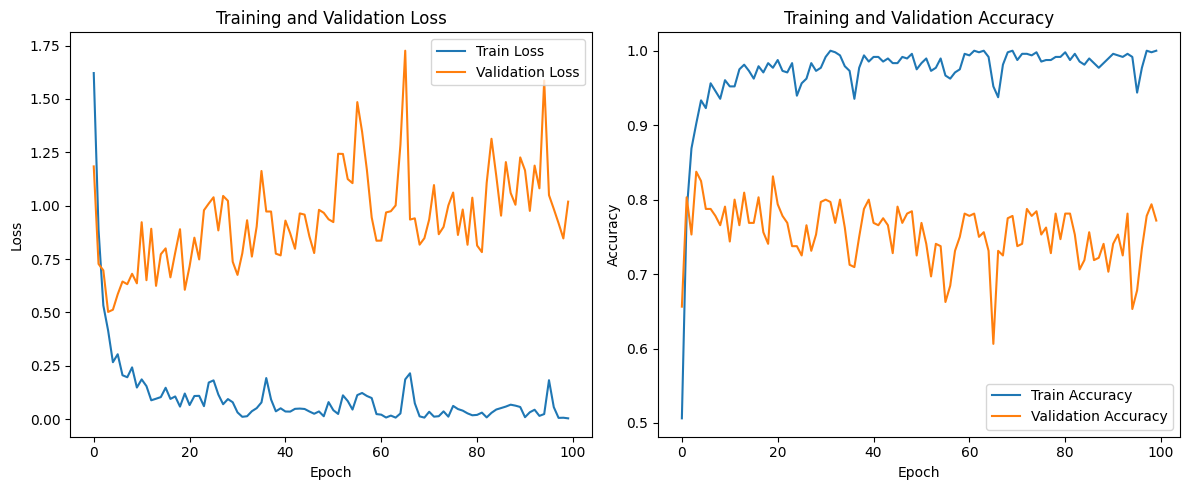

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: to() received an invalid combination of arguments - got (list), but expected one of:
 * (torch.device device = None, torch.dtype dtype = None, bool non_blocking = False, bool copy = False, *, torch.memory_format memory_format = None)
 * (torch.dtype dtype, bool non_blocking = False, bool copy = False, *, torch.memory_format memory_format = None)
 * (Tensor tensor, bool non_blocking = False, bool copy = False, *, torch.memory_format memory_format = None)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from transformers import ViTForImageClassification, ViTFeatureExtractor
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import random

class ViTTrainer:
    def __init__(self, class_names, device=None):
        self.class_names = class_names
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load ViT model
        self.model = ViTForImageClassification.from_pretrained(
            "google/vit-base-patch16-224-in21k", num_labels=len(class_names)
        )
        self.model.to(self.device)

        # Load feature extractor for input shape information
        self.feature_extractor = ViTFeatureExtractor.from_pretrained(
            "google/vit-base-patch16-224-in21k"
        )

        # Define loss function and optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-4)

    def train(self, train_loader, val_loader, num_epochs=10):
        train_losses, train_accuracies = [], []
        val_losses, val_accuracies = [], []

        for epoch in range(num_epochs):
            self.model.train()
            train_loss, train_correct = 0, 0

            for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
                images, labels = images.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(pixel_values=images)
                loss = self.criterion(outputs.logits, labels)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                train_correct += (outputs.logits.argmax(1) == labels).sum().item()

            train_loss /= len(train_loader)
            train_accuracy = train_correct / len(train_loader.dataset)

            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)

            # Validation
            val_loss, val_accuracy = self.evaluate(val_loader)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        return train_losses, train_accuracies, val_losses, val_accuracies

    def evaluate(self, loader):
        self.model.eval()
        total_loss, correct = 0, 0

        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(pixel_values=images)
                loss = self.criterion(outputs.logits, labels)
                total_loss += loss.item()
                correct += (outputs.logits.argmax(1) == labels).sum().item()

        return total_loss / len(loader), correct / len(loader.dataset)

    def plot_learning_curves(self, train_losses, train_accuracies, val_losses, val_accuracies):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')

        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label='Train Accuracy')
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Training and Validation Accuracy')

        plt.tight_layout()
        plt.show()

# Use the existing data loading and augmentation code

# Initialize the trainer
trainer = ViTTrainer(class_names)

# Train the model and get the learning curves data
train_losses, train_accuracies, val_losses, val_accuracies = trainer.train(train_loader, val_loader, num_epochs=100)

# Plot the learning curves
trainer.plot_learning_curves(train_losses, train_accuracies, val_losses, val_accuracies)

# Save the trained model
torch.save(trainer.model.state_dict(), "vit_classification_model_final.pth")

# Evaluate the model on the validation set
evaluator = ViTEvaluator("vit_classification_model_final.pth", class_names)
report, conf_matrix = evaluator.evaluate(val_loader)
print(report)
print(conf_matrix)

Resnet50(1st try)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import os
import copy
from collections import Counter
from torch.utils.data.sampler import WeightedRandomSampler
import numpy as np

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Data directory
data_dir = '/content/drive/MyDrive/clothing_data'

# Load the full dataset
full_dataset = datasets.ImageFolder(data_dir, data_transforms['train'])

# Split the dataset into training and validation sets (80/20 split)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Class balancing using WeightedRandomSampler
class_count = Counter([label for _, label in train_dataset])
class_weights = 1. / np.array([class_count[i] for i in range(len(class_count))])
samples_weight = np.array([class_weights[t] for _, t in train_dataset])

sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

# Create dataloaders for training and validation
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
}

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = full_dataset.classes

# Freeze layers and modify ResNet50 with Dropout and custom classifier
def initialize_resnet50(num_classes):
    model_ft = models.resnet50(pretrained=True)

    # Freeze all layers in the ResNet model
    for param in model_ft.parameters():
        param.requires_grad = False

    # Replace the FC layer with custom classifier for 8 classes and add Dropout
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),      # Add a dense layer with 512 units
        nn.ReLU(),                     # Activation
        nn.Dropout(0.5),               # Dropout to prevent overfitting
        nn.Linear(512, num_classes)    # Final output layer for 8 classes
    )

    return model_ft

# Model initialization
num_classes = 8  # for clothing dataset
model_ft = initialize_resnet50(num_classes)
model_ft = model_ft.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.fc.parameters(), lr=0.001)  # Only optimize the new layers

# Learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train the model with early stopping and evaluation
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=50, patience=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    early_stop_counter = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if accuracy improves on validation
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                early_stop_counter = 0  # Reset patience counter
            elif phase == 'val':
                early_stop_counter += 1  # Increase patience counter

            if early_stop_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                model.load_state_dict(best_model_wts)
                return model  # Stop training early if no improvement

        scheduler.step()

    print(f'Best val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model

# Training the ResNet50 model
best_model = train_model(model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler)

# Save the best model
torch.save(best_model.state_dict(), 'best_resnet50_model.pth')
print("Best model saved as 'best_resnet50_model.pth'")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can als

Epoch 0/49
----------
train Loss: 2.1945 Acc: 0.1562
val Loss: 1.9778 Acc: 0.2625
Epoch 1/49
----------
train Loss: 1.9128 Acc: 0.2531
val Loss: 1.8033 Acc: 0.3188
Epoch 2/49
----------
train Loss: 1.8274 Acc: 0.2812
val Loss: 1.7542 Acc: 0.3063
Epoch 3/49
----------
train Loss: 1.6928 Acc: 0.3531
val Loss: 1.6177 Acc: 0.4125
Epoch 4/49
----------
train Loss: 1.6370 Acc: 0.3969
val Loss: 1.4886 Acc: 0.4813
Epoch 5/49
----------
train Loss: 1.5913 Acc: 0.3953
val Loss: 1.4865 Acc: 0.4688
Epoch 6/49
----------
train Loss: 1.5571 Acc: 0.4219
val Loss: 1.4150 Acc: 0.5062
Epoch 7/49
----------
train Loss: 1.5430 Acc: 0.4250
val Loss: 1.3744 Acc: 0.5625
Epoch 8/49
----------
train Loss: 1.5353 Acc: 0.4266
val Loss: 1.3753 Acc: 0.5500
Epoch 9/49
----------
train Loss: 1.5108 Acc: 0.4625
val Loss: 1.3661 Acc: 0.5250
Epoch 10/49
----------
train Loss: 1.4453 Acc: 0.4734
val Loss: 1.3592 Acc: 0.5062
Epoch 11/49
----------
train Loss: 1.4539 Acc: 0.4688
val Loss: 1.4236 Acc: 0.5188
Epoch 12/49
--

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=50, patience=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    early_stop_counter = 0

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save loss and accuracy for plotting later
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)

            # Deep copy the model if accuracy improves on validation
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                early_stop_counter = 0  # Reset patience counter
            elif phase == 'val':
                early_stop_counter += 1  # Increase patience counter

            if early_stop_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                model.load_state_dict(best_model_wts)
                return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

        scheduler.step()

    print(f'Best val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

# Train the model and save history
best_model, train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler)

# Save the best model
torch.save(best_model.state_dict(), 'best_resnet50_model.pth')

# Save the training/validation history to visualize later
torch.save({
    'train_loss': train_loss_history,
    'val_loss': val_loss_history,
    'train_acc': train_acc_history,
    'val_acc': val_acc_history
}, 'training_history.pth')

print("Training history saved as 'training_history.pth'")

Epoch 0/49
----------
train Loss: 1.5050 Acc: 0.4344
val Loss: 1.3691 Acc: 0.5312
Epoch 1/49
----------
train Loss: 1.4437 Acc: 0.4750
val Loss: 1.3552 Acc: 0.5250
Epoch 2/49
----------
train Loss: 1.4647 Acc: 0.4500
val Loss: 1.4082 Acc: 0.4688
Epoch 3/49
----------
train Loss: 1.3706 Acc: 0.5031
val Loss: 1.4463 Acc: 0.4625
Epoch 4/49
----------
train Loss: 1.4450 Acc: 0.4641
val Loss: 1.3609 Acc: 0.5062
Epoch 5/49
----------
train Loss: 1.3979 Acc: 0.4938
val Loss: 1.4422 Acc: 0.4688
Epoch 6/49
----------
train Loss: 1.5186 Acc: 0.4313
val Loss: 1.4170 Acc: 0.4563
Epoch 7/49
----------
train Loss: 1.4344 Acc: 0.4578
val Loss: 1.3049 Acc: 0.5500
Epoch 8/49
----------
train Loss: 1.4120 Acc: 0.5016
val Loss: 1.3900 Acc: 0.5125
Epoch 9/49
----------
train Loss: 1.4477 Acc: 0.4656
val Loss: 1.3725 Acc: 0.5563
Epoch 10/49
----------
train Loss: 1.4289 Acc: 0.4734
val Loss: 1.3804 Acc: 0.5250
Epoch 11/49
----------
train Loss: 1.4566 Acc: 0.4547
val Loss: 1.3335 Acc: 0.5000
Epoch 12/49
--

<ipython-input-8-5de29a083410>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  history = torch.load('training_history.pth')


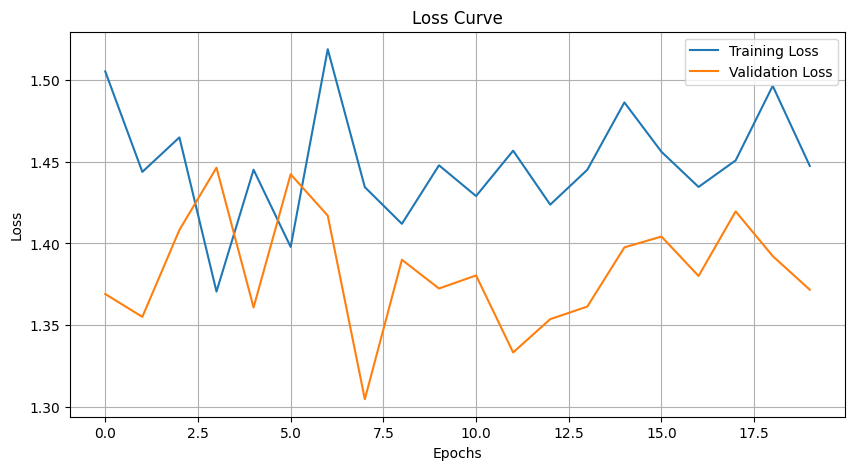

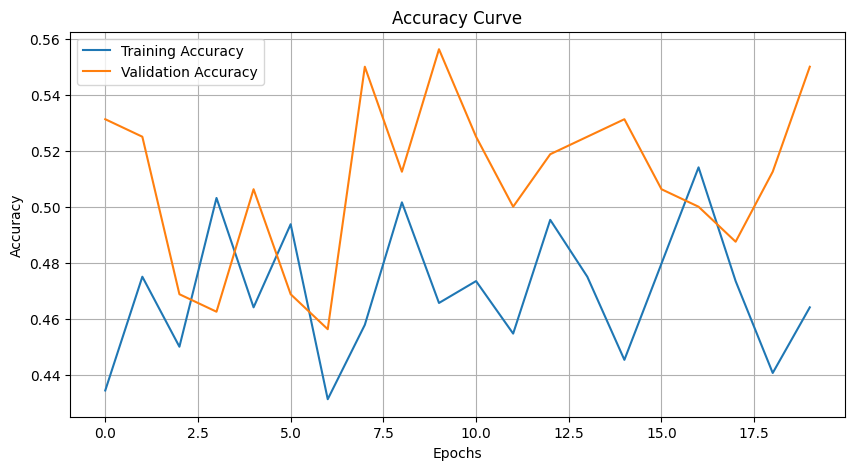

In [ ]:
import torch
import matplotlib.pyplot as plt

# Load the training and validation history
history = torch.load('training_history.pth')

train_loss = history['train_loss']
val_loss = history['val_loss']
train_acc = history['train_acc']
val_acc = history['val_acc']

# Convert tensors to lists for plotting
train_acc = [acc.cpu().item() for acc in train_acc]
val_acc = [acc.cpu().item() for acc in val_acc]

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy Curves
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


**Resnet50 (worked well)**

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can als

Epoch 0/49
----------
train Loss: 1.9166 Acc: 0.2828
val Loss: 1.6254 Acc: 0.4625
Epoch 1/49
----------
train Loss: 1.4089 Acc: 0.5438
val Loss: 1.2099 Acc: 0.6063
Epoch 2/49
----------
train Loss: 1.1282 Acc: 0.5906
val Loss: 0.9445 Acc: 0.6813
Epoch 3/49
----------
train Loss: 0.8870 Acc: 0.6875
val Loss: 0.9730 Acc: 0.6438
Epoch 4/49
----------
train Loss: 0.8313 Acc: 0.6828
val Loss: 0.8147 Acc: 0.7125
Epoch 5/49
----------
train Loss: 0.8549 Acc: 0.7016
val Loss: 0.8178 Acc: 0.6938
Epoch 6/49
----------
train Loss: 0.6751 Acc: 0.7625
val Loss: 0.8156 Acc: 0.7125
Epoch 7/49
----------
train Loss: 0.6441 Acc: 0.7734
val Loss: 0.7125 Acc: 0.7500
Epoch 8/49
----------
train Loss: 0.6729 Acc: 0.7547
val Loss: 0.7429 Acc: 0.6938
Epoch 9/49
----------
train Loss: 0.6482 Acc: 0.7703
val Loss: 0.6212 Acc: 0.7688
Epoch 10/49
----------
train Loss: 0.5450 Acc: 0.8234
val Loss: 0.6478 Acc: 0.7625
Epoch 11/49
----------
train Loss: 0.5817 Acc: 0.7906
val Loss: 0.7581 Acc: 0.7313
Epoch 12/49
--

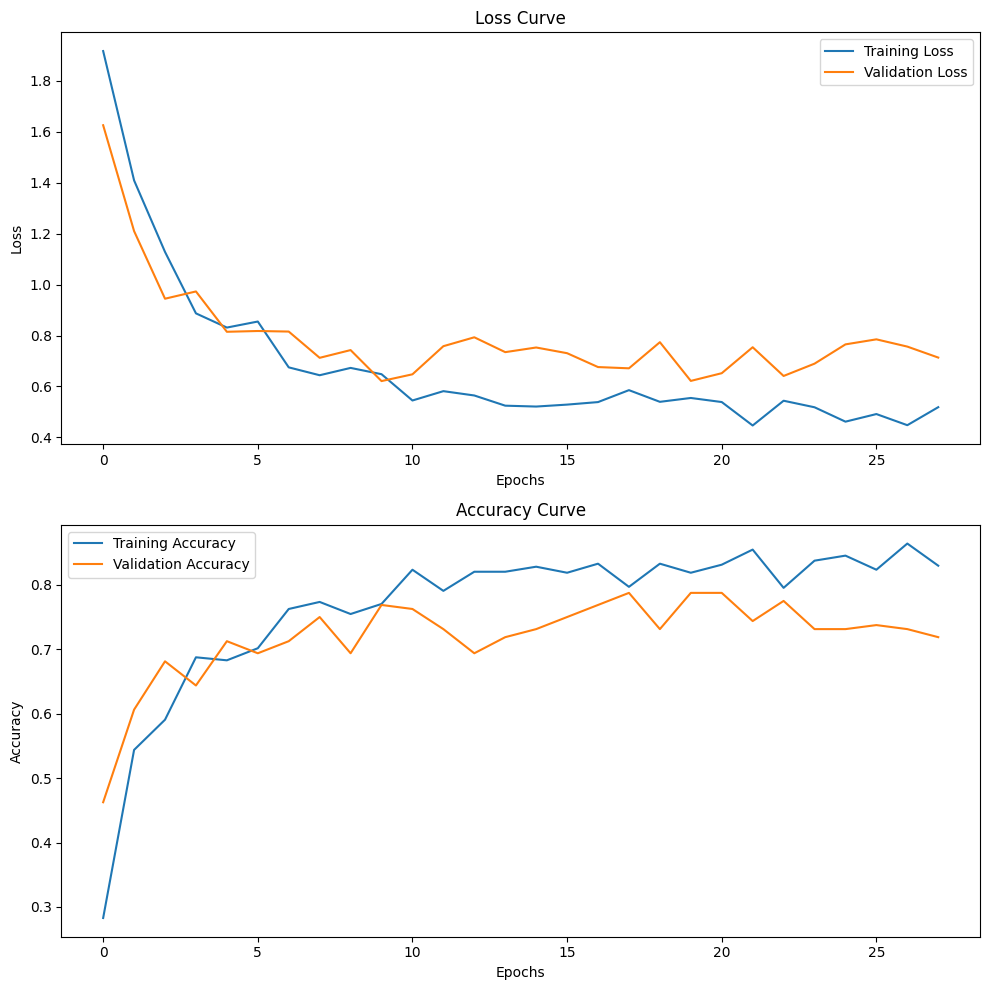

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler, random_split
import os
import copy
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data augmentation and normalization for training and validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/clothing_data'
dataset = datasets.ImageFolder(data_dir, data_transforms['train'])

# 80/20 split for training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Balancing classes in training set
train_targets = [dataset.targets[i] for i in train_dataset.indices]
class_counts = np.bincount(train_targets)
class_weights = 1. / class_counts
sample_weights = [class_weights[t] for t in train_targets]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

# Create dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = dataset.classes

# Load ResNet50 pretrained model
model_ft = models.resnet50(pretrained=True)

# Modify the fully connected layer to match the number of classes
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),  # Dropout added to reduce overfitting
    nn.Linear(512, len(class_names))  # Adjust for the number of classes
)

model_ft = model_ft.to(device)

# Freeze some of the layers and unfreeze the later ones
ct = 0
for child in model_ft.children():
    ct += 1
    if ct < 7:  # Freeze layers 1 to 6
        for param in child.parameters():
            param.requires_grad = False

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Adam optimizer with lower learning rate and weight decay for regularization
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-4, weight_decay=1e-5)

# Learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Early stopping parameters
patience = 10
early_stop_counter = 0
best_model_wts = copy.deepcopy(model_ft.state_dict())
best_acc = 0.0

# Training function with early stopping and gradient clipping
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    global early_stop_counter, best_acc, best_model_wts
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                scheduler.step()

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save losses and accuracies for plotting
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

            # Deep copy the model if it has the best accuracy so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                early_stop_counter = 0
            elif phase == 'val':
                early_stop_counter += 1

        # Early stopping
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

# Train the model
model_ft, train_loss, val_loss, train_acc, val_acc = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50
)

# Plot accuracy and loss curves
def plot_curves(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(10, 10))

    # Plot Loss Curve
    plt.subplot(2, 1, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Plot Accuracy Curve
    plt.subplot(2, 1, 2)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call plot function to visualize results
plot_curves(train_loss, val_loss, train_acc, val_acc)

ViT(used vit_b_16)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 59.3MB/s]


Epoch 0/49
----------
train Loss: 2.0054 Acc: 0.2687
val Loss: 1.9052 Acc: 0.4188
Epoch 1/49
----------
train Loss: 1.8001 Acc: 0.4609
val Loss: 1.7295 Acc: 0.5500
Epoch 2/49
----------
train Loss: 1.6317 Acc: 0.5281
val Loss: 1.5343 Acc: 0.5687
Epoch 3/49
----------
train Loss: 1.4772 Acc: 0.5563
val Loss: 1.4170 Acc: 0.5750
Epoch 4/49
----------
train Loss: 1.3038 Acc: 0.6219
val Loss: 1.2977 Acc: 0.6250
Epoch 5/49
----------
train Loss: 1.1883 Acc: 0.6641
val Loss: 1.1824 Acc: 0.6375
Epoch 6/49
----------
train Loss: 1.1543 Acc: 0.6438
val Loss: 1.1117 Acc: 0.6500
Epoch 7/49
----------
train Loss: 1.0708 Acc: 0.6656
val Loss: 1.0667 Acc: 0.6750
Epoch 8/49
----------
train Loss: 1.0768 Acc: 0.6625
val Loss: 1.1172 Acc: 0.6313
Epoch 9/49
----------
train Loss: 1.0979 Acc: 0.6406
val Loss: 1.0931 Acc: 0.7000
Epoch 10/49
----------
train Loss: 1.0456 Acc: 0.6719
val Loss: 1.1047 Acc: 0.6250
Epoch 11/49
----------
train Loss: 1.0676 Acc: 0.6484
val Loss: 1.0940 Acc: 0.6938
Epoch 12/49
--

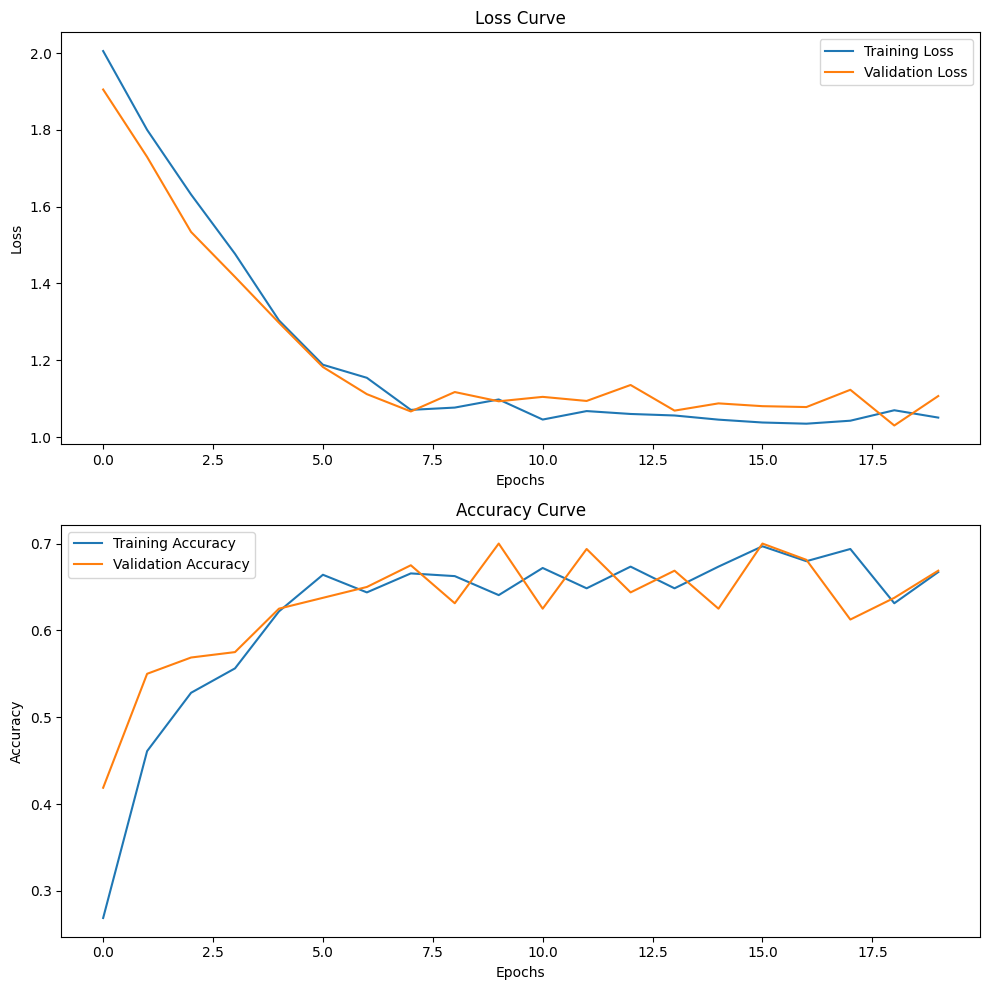

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import matplotlib.pyplot as plt
import os
import copy
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data augmentation and normalization for training and validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/clothing_data'
dataset = datasets.ImageFolder(data_dir, data_transforms['train'])

# 80/20 split for training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Balancing classes in training set
train_targets = [dataset.targets[i] for i in train_dataset.indices]
class_counts = np.bincount(train_targets)
class_weights = 1. / class_counts
sample_weights = [class_weights[t] for t in train_targets]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

# Create dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = dataset.classes

# Load Vision Transformer (ViT) pretrained model
vit_model = models.vit_b_16(pretrained=True)  # Use pre-trained ViT base model

# Modify the classifier to match the number of classes in your dataset
vit_model.heads = nn.Sequential(
    nn.Linear(vit_model.heads.head.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),  # Dropout to reduce overfitting
    nn.Linear(512, len(class_names))  # Output layer matching number of classes
)

vit_model = vit_model.to(device)

# Freeze all layers except the classification head
for param in vit_model.parameters():
    param.requires_grad = False

# Unfreeze the classification head
for param in vit_model.heads.parameters():
    param.requires_grad = True

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Adam optimizer with learning rate and weight decay for regularization
optimizer_ft = optim.Adam(vit_model.heads.parameters(), lr=1e-4, weight_decay=1e-5)

# Learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Early stopping parameters
patience = 10
early_stop_counter = 0
best_model_wts = copy.deepcopy(vit_model.state_dict())
best_acc = 0.0

# Training function with early stopping and gradient clipping
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    global early_stop_counter, best_acc, best_model_wts
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                scheduler.step()

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save losses and accuracies for plotting
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

            # Deep copy the model if it has the best accuracy so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                early_stop_counter = 0
            elif phase == 'val':
                early_stop_counter += 1

        # Early stopping
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

# Train the model
vit_model, train_loss, val_loss, train_acc, val_acc = train_model(
    vit_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50
)

# Plot accuracy and loss curves
def plot_curves(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(10, 10))

    # Plot Loss Curve
    plt.subplot(2, 1, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Plot Accuracy Curve
    plt.subplot(2, 1, 2)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call plot function to visualize results
plot_curves(train_loss, val_loss, train_acc, val_acc)


ViT (increased batch size)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/49
----------
train Loss: 2.0805 Acc: 0.1266
val Loss: 2.0179 Acc: 0.2125
Epoch 1/49
----------
train Loss: 2.0042 Acc: 0.2188
val Loss: 1.9479 Acc: 0.3500
Epoch 2/49
----------
train Loss: 1.9264 Acc: 0.3109
val Loss: 1.9037 Acc: 0.3938
Epoch 3/49
----------
train Loss: 1.8826 Acc: 0.3828
val Loss: 1.8551 Acc: 0.4688
Epoch 4/49
----------
train Loss: 1.8415 Acc: 0.4219
val Loss: 1.8361 Acc: 0.4563
Epoch 5/49
----------
train Loss: 1.7958 Acc: 0.4578
val Loss: 1.7859 Acc: 0.4375
Epoch 6/49
----------
train Loss: 1.7767 Acc: 0.4750
val Loss: 1.7601 Acc: 0.5188
Epoch 7/49
----------
train Loss: 1.7379 Acc: 0.5000
val Loss: 1.7671 Acc: 0.5000
Epoch 8/49
----------
train Loss: 1.7224 Acc: 0.5234
val Loss: 1.7581 Acc: 0.4750
Epoch 9/49
----------
train Loss: 1.7647 Acc: 0.4641
val Loss: 1.7345 Acc: 0.4875
Epoch 10/49
----------
train Loss: 1.7218 Acc: 0.5375
val Loss: 1.7529 Acc: 0.5125
Epoch 11/49
----------
train Loss: 1.7258 Acc: 0.5078
val Loss: 1.7357 Acc: 0.5250
Epoch 12/49
--

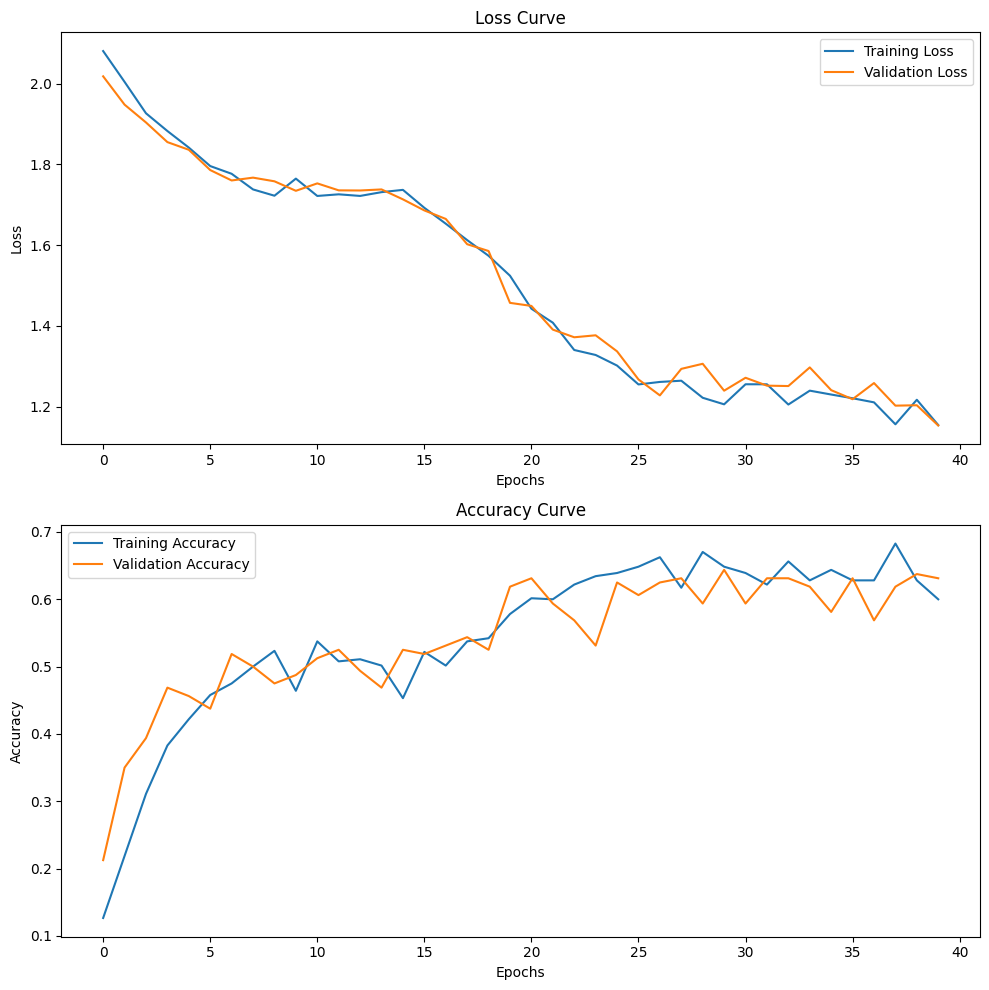

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import matplotlib.pyplot as plt
import os
import copy
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/clothing_data'
dataset = datasets.ImageFolder(data_dir, data_transforms['train'])

# 80/20 split for training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Balancing classes in training set
train_targets = [dataset.targets[i] for i in train_dataset.indices]
class_counts = np.bincount(train_targets)
class_weights = 1. / class_counts
sample_weights = [class_weights[t] for t in train_targets]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

# Create dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=64, sampler=sampler, num_workers=4),  # Increased batch size
    'val': DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = dataset.classes

# Load Vision Transformer (ViT) pretrained model
vit_model = models.vit_b_16(pretrained=True)

# Unfreeze the last 2 transformer layers + classification head for fine-tuning
for name, param in vit_model.named_parameters():
    if 'encoder.layer.10' in name or 'encoder.layer.11' in name or 'heads' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Modify the classifier to match the number of classes in your dataset
vit_model.heads = nn.Sequential(
    nn.Linear(vit_model.heads.head.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),  # Dropout to reduce overfitting
    nn.Linear(512, len(class_names))  # Output layer matching number of classes
)

vit_model = vit_model.to(device)

# Loss function and optimizer (AdamW is better suited for transformers)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.AdamW(vit_model.parameters(), lr=1e-4, weight_decay=1e-5)

# Cosine Annealing Scheduler
exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=10)

# Training function with early stopping and gradient accumulation
def train_model(model, criterion, optimizer, scheduler, num_epochs=50, patience=10, accumulation_steps=2):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    early_stop_counter = 0
    train_loss_history, val_loss_history, train_acc_history, val_acc_history = [], [], [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Gradient accumulation logic
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        if (i + 1) % accumulation_steps == 0:  # Simulate larger batch size
                            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                            optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                scheduler.step()

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

            # Early stopping and saving best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                early_stop_counter = 0
            elif phase == 'val':
                early_stop_counter += 1

        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

# Train the model
vit_model, train_loss, val_loss, train_acc, val_acc = train_model(
    vit_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50
)

# Plot accuracy and loss curves
def plot_curves(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(10, 10))

    # Plot Loss Curve
    plt.subplot(2, 1, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Plot Accuracy Curve
    plt.subplot(2, 1, 2)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call plot function to visualize results
plot_curves(train_loss, val_loss, train_acc, val_acc)


Combined models

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Define a custom model that combines DenseNet and MobileNetV3
class CombinedModel(nn.Module):
    def __init__(self, num_classes):
        super(CombinedModel, self).__init__()

        # Load pre-trained DenseNet (from torchvision)
        self.densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)  # You can choose different variants
        self.densenet_features = nn.Sequential(*list(self.densenet.children())[:-1])  # Remove the classifier

        # Load pre-trained MobileNetV3 from torchvision
        self.mobilenet = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)
        self.mobilenet_features = nn.Sequential(*list(self.mobilenet.children())[:-1])  # Remove the classifier

        # Combine feature maps from both models
        # Calculate the actual combined_feature_size after flattening and concatenating
        dummy_input = torch.randn(1, 3, 224, 224)  # Example input
        densenet_features_shape = self.densenet_features(dummy_input).view(1, -1).shape[1]
        mobilenet_features_shape = self.mobilenet_features(dummy_input).view(1, -1).shape[1]
        self.combined_feature_size = densenet_features_shape + mobilenet_features_shape


        # New classification head that combines both feature extractors
        self.classifier = nn.Sequential(
            nn.Linear(self.combined_feature_size, 512), # Adjust the input size of the first Linear layer
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Extract features from DenseNet
        densenet_features = self.densenet_features(x)
        densenet_features = densenet_features.view(densenet_features.size(0), -1)

        # Extract features from MobileNetV3
        mobilenet_features = self.mobilenet_features(x)
        mobilenet_features = mobilenet_features.view(mobilenet_features.size(0), -1)

        # Concatenate features from both models
        combined_features = torch.cat((densenet_features, mobilenet_features), dim=1)

        # Pass through classifier
        out = self.classifier(combined_features)
        return out

# Create the model
num_classes = 8  # Adjust this based on the number of classes in your dataset
model = CombinedModel(num_classes)

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define dataset path (replace 'your_dataset_folder' with the actual folder path)
data_dir = '/content/drive/MyDrive/clothing_data'  # Path to your dataset folder where each class is a subfolder

# Define transformations (resize to 224x224 for DenseNet and MobileNet, normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Both models expect 224x224 input size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Adjust these values based on your dataset's mean/std
])

# Load dataset using ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split the dataset into train and test sets (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print dataset info
print(f'Total images: {len(dataset)}, Train size: {train_size}, Test size: {test_size}')


Total images: 800, Train size: 640, Test size: 160


In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.cuda(), labels.cuda()  # Move data to GPU if available

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.cuda(), labels.cuda()

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=50)

# Evaluate the model
evaluate_model(model, test_loader)


Epoch [1/50], Loss: 0.9406458265264519
Epoch [2/50], Loss: 0.8567812746390701
Epoch [3/50], Loss: 0.6796706192195415
Epoch [4/50], Loss: 0.4863005498424172
Epoch [5/50], Loss: 0.3449641834944487
Epoch [6/50], Loss: 0.5019818891771137
Epoch [7/50], Loss: 0.7176395894959569
Epoch [8/50], Loss: 0.6250823875889182
Epoch [9/50], Loss: 0.3687117577530444
Epoch [10/50], Loss: 0.5490681458730251
Epoch [11/50], Loss: 0.551289788633585
Epoch [12/50], Loss: 0.3234083809889853
Epoch [13/50], Loss: 0.47628267370164395
Epoch [14/50], Loss: 0.4041450074175373
Epoch [15/50], Loss: 0.40891858004033566
Epoch [16/50], Loss: 0.36071891337633133
Epoch [17/50], Loss: 0.18090791168506257
Epoch [18/50], Loss: 0.5593602817156352
Epoch [19/50], Loss: 0.5402995761483907
Epoch [20/50], Loss: 0.5216265772702172
Epoch [21/50], Loss: 0.49028128702193496
Epoch [22/50], Loss: 0.2057692177593708
Epoch [23/50], Loss: 0.21383328361989698
Epoch [24/50], Loss: 0.13980010193481576
Epoch [25/50], Loss: 0.14325192144679022
Ep

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Additional imports for ROC, AUC, and Confusion Matrix
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Define Attention Layer (Squeeze-and-Excitation style)
class AttentionLayer(nn.Module):
    def __init__(self, input_size, reduction=16):
        super(AttentionLayer, self).__init__()
        self.fc1 = nn.Linear(input_size, input_size // reduction, bias=False)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(input_size // reduction, input_size, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        attn = self.fc1(x)
        attn = self.relu(attn)
        attn = self.fc2(attn)
        attn = self.sigmoid(attn)
        return x * attn  # Scale the features with attention weights

# Combined DenseNet and MobileNet model with Attention, Dropout, and Regularization
class CombinedModel(nn.Module):
    def __init__(self, num_classes):
        super(CombinedModel, self).__init__()

        # Load pre-trained DenseNet (from torchvision)
        self.densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        self.densenet_features = nn.Sequential(*list(self.densenet.children())[:-1])  # Remove classifier

        # Load pre-trained MobileNetV3 from torchvision
        self.mobilenet = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)
        self.mobilenet_features = nn.Sequential(*list(self.mobilenet.children())[:-1])  # Remove classifier

        # Global Average Pooling (GAP) after feature extraction
        self.gap = nn.AdaptiveAvgPool2d(1)  # Adaptive pooling to (1, 1)

        # Calculate the actual combined feature size dynamically based on the models
        self.densenet_feature_size = self.densenet.classifier.in_features
        self.mobilenet_feature_size = self.mobilenet.classifier[0].in_features
        self.combined_feature_size = self.densenet_feature_size + self.mobilenet_feature_size

        # Attention layer for combined features
        self.attention = AttentionLayer(self.combined_feature_size)

        # Classification head (with dropout to avoid overfitting)
        self.classifier = nn.Sequential(
            nn.Linear(self.combined_feature_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),  # Increase dropout for regularization
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),  # Another dropout layer
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Extract features from DenseNet
        densenet_features = self.densenet_features(x)
        densenet_features = self.gap(densenet_features)  # Apply GAP
        densenet_features = densenet_features.view(densenet_features.size(0), -1)

        # Extract features from MobileNet
        mobilenet_features = self.mobilenet_features(x)
        mobilenet_features = self.gap(mobilenet_features)  # Apply GAP
        mobilenet_features = mobilenet_features.view(mobilenet_features.size(0), -1)

        # Concatenate the feature maps
        combined_features = torch.cat((densenet_features, mobilenet_features), dim=1)

        # Pass through attention mechanism
        combined_features = self.attention(combined_features)

        # Classification head
        out = self.classifier(combined_features)
        return out

# Data Augmentation: Enhanced with random cropping, color jitter, etc.
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Random crop and resize to 224x224
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),  # Random color jitter
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for consistency
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset using ImageFolder
data_dir = '/content/drive/MyDrive/clothing_data'
dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)

# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model Checkpointing (save the model with the lowest validation loss)
def save_model(model, optimizer, epoch, loss, path='best_model.pth'):
    state = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch,
        'loss': loss
    }
    torch.save(state, path)

# Training and Evaluation Functions
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    best_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')

        # Validate model after each epoch
        avg_val_loss = validate_model(model, test_loader, criterion)
        print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}')

        # Save the model with the lowest validation loss
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            save_model(model, optimizer, epoch, best_loss)
            print(f"Model saved at epoch {epoch+1} with validation loss {best_loss:.4f}")

def validate_model(model, test_loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(test_loader)

def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')

# Instantiate the model, criterion, and optimizer
num_classes = 8  # Adjust this based on your dataset
model = CombinedModel(num_classes).cuda()

# Use CrossEntropyLoss and Adam optimizer with weight decay (L2 regularization)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Train and Evaluate the Model
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)

# Load the best saved model for final evaluation
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model'])
evaluate_model(model, test_loader)

# Evaluation function to include AUC, ROC, Classification Report, and Confusion Matrix
def evaluate_model(model, test_loader, num_classes):
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.cuda(), labels.cuda()

            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)  # Get probabilities for AUC/ROC

            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_prob.extend(probabilities.cpu().numpy())

    # Classification Report
    print("Classification Report:\n")
    print(classification_report(y_true, y_pred))

    # Confusion Matrix
    print("Confusion Matrix:\n")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # ROC Curve and AUC for each class
    y_true_bin = label_binarize(y_true, classes=range(num_classes))  # Binarize labels for multi-class ROC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], np.array(y_prob)[:, i])
        roc_auc[i] = roc_auc_score(y_true_bin[:, i], np.array(y_prob)[:, i])

    # Plot ROC curve for each class
    plt.figure()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'yellow'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # AUC Score (micro-average)
    print(f'AUC (micro-average): {roc_auc_score(y_true_bin, y_prob, average="micro"):.4f}')

# Train and Validate as before (without changes)

# Load the best saved model for final evaluation
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model'])

# Evaluate the model with AUC, ROC, and Confusion Matrix
evaluate_model(model, test_loader, num_classes=num_classes)

OutOfMemoryError: CUDA out of memory. Tried to allocate 14.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 1.06 MiB is free. Process 4280 has 14.74 GiB memory in use. Of the allocated memory 14.12 GiB is allocated by PyTorch, and 503.69 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)